Sample 1: [9.206 5.806 9.795 7.452], 0.014636
Sample 2: [9.123 5.265 8.88  5.74 ], 0.011781
Sample 3: [0.661 2.222 3.34  7.025], 2.3e-05
Sample 4: [2.022 2.641 2.202 2.139], 3.2e-05
Sample 5: [0.501 2.135 3.23  1.475], 8.6e-05
Sample 6: [0.363 1.749 2.184 1.032], 1.7e-05
Sample 7: [5.306 5.682 0.108 5.365], 0.001569
Sample 8: [0.608 8.135 1.662 2.234], 0.004223
Sample 9: [5.049 3.675 4.728 4.297], 0.000879
Sample 10: [7.569 8.265 5.136 5.122], 0.006847
Sample 11: [0.16  6.248 5.637 4.814], 0.001882
Sample 12: [3.649 6.6   2.837 8.771], 0.001704
Conductivity Function:
[10. 10. 10.  0.] 0.026202 0.026202
[1.e+01 1.e+01 1.e+01 8.e-03] 0.026201 0.026201
[10.  0. 10.  0.] 0.020102 0.020102
Non-Bayesian Optimization:
[10. 10. 10. 10.] 0.021217 0.024302
[10. 10. 10.  0.] 0.019906 0.026202
[10.  0. 10. 10.] 0.014653 0.018202
Upper Confidence Bound:
[10. 10. 10.  0.] [0.019906] 0.026202
[10.     7.098 10.     0.   ] [0.0169] 0.020263
[10.  0. 10. 10.] [0.014653] 0.018202


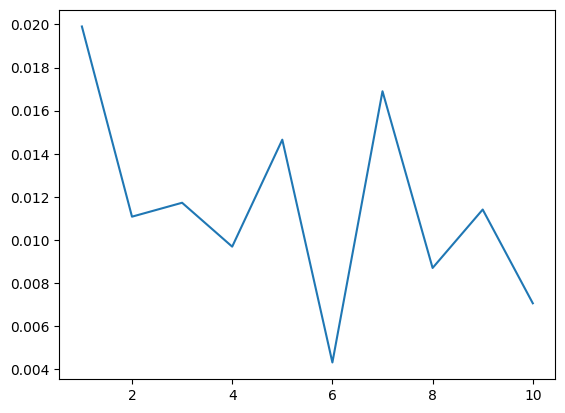

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)
y = conductivity_func(X).round(6)

for i in range(len(y)):
    print(f'Sample {i+1}: {X[i]}, {y[i]}')

#===========================================================================================================#
#Declaring Machine Learning Model Used

#kernel = Matern(length_scale=1e+04, nu=1.5, length_scale_bounds=(100.0, 10000.0)) * DP(sigma_0=1e+04, sigma_0_bounds=(1.0, 100000.0))
#GPR = GaussianProcessRegressor(kernel = kernel, alpha=1e-3, normalize_y=True)
kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))
GPR = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-8)


#===========================================================================================================#
#Bayesian Optimization

def guess_in_bounds(bounds):
    return [(b[1] - b[0]) * np.random.random() + b[0] for b in bounds]

def acquisition_function1(x, model, explore_weight, *args):
    pred, std = model.predict([x], return_std=True)
    return -(pred-std*explore_weight)

def acquisition_function2(x, model, explore_weight, *args):
    pred, std = model.predict([x], return_std=True)
    return -(pred+std*explore_weight)

def acquisition_function3(x, model, best_y, *args):
    pred, std = model.predict([x], return_std=True)
    return -(norm.cdf((pred-best_y)/std))

def acquisition_function4(x, model, best_y, xi, *args):
    pred, std = model.predict([x], return_std=True)
    return -(pred-best_y-xi)*(norm.cdf((pred-best_y-xi)/std)+norm.pdf((pred-best_y-xi)/std))

bounds = [(0, 10)] * concentrations

#===========================================================================================================#
#Global Minimum

samples_per_method = 3

def in_list(arr, lst):
    if lst == []:
        return False
    for item in lst:
        if np.allclose(arr, item, atol=1e-3):
            return True
    return False

def bayesian_optimize(func, bounds, additional_args=None, y_max_needed=False, 
                      model = clone(GPR).fit(X, y)):
    global_mins = []
    iterations = 10
    current_iteration = 0
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    while (current_iteration<iterations) or (len(global_mins)<samples_per_method):
        np.random.seed(current_iteration)
        GPR.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        if y_max_needed==False:
            args = (GPR, additional_args)
        else:
            args = (GPR, max(y_copy), additional_args)
        global_min = minimize(func, guess, bounds=bounds, method='Nelder-Mead', args=args)
        x_guess = global_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            global_mins.append((x_guess, y_guess))
        current_iteration += 1
    x_axis = np.arange(1, len(global_mins)+1)
    y_axis = [x[1] for x in global_mins]
    plt.plot(x_axis, y_axis)
    return sorted(global_mins, key=lambda x: x[1], reverse=True)

def non_bayesian_optimize(func, bounds, additional_args=None, model_used=False,
                          model = clone(GPR).fit(X, y)):
    global_mins = []
    X_copy = [val for val in X]
    iterations = 12
    current_iteration = 0
    while (current_iteration<iterations) or (len(global_mins)<samples_per_method):
        np.random.seed(current_iteration)
        guess = guess_in_bounds(bounds)
        if model_used==False:
            args = additional_args
        else:
            model.fit(X, y)
            args = model
        global_min = minimize(func, guess, bounds=bounds, method='Nelder-Mead', args=(args))
        x_guess = global_min.x.round(3)
        y_guess = global_min.fun.round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            global_mins.append((x_guess, -y_guess))
        current_iteration += 1
    return sorted(global_mins, key=lambda x: x[1], reverse=True)

def ML_func(guess, model):
    return -model.predict(guess.reshape(1, -1))

ucb_exploration_weight = 7.5
xi = 0.1

mins_to_test = {
    'Conductivity Function':        non_bayesian_optimize(conductivity_func, bounds, additional_args=(True)),
    'Non-Bayesian Optimization':    non_bayesian_optimize(ML_func, bounds, model_used=True),
    'Upper Confidence Bound':       bayesian_optimize(acquisition_function2, bounds, additional_args=(ucb_exploration_weight)),
    #'Probability of Improvement':   bayesian_optimize(acquisition_function3, bounds, y_max_needed=True),
    #'Expected Improvement':         bayesian_optimize(acquisition_function4, bounds, additional_args=(xi), y_max_needed=True)   
}

#Prints concentrations, predicted value, and actual value
for key in mins_to_test.keys():
    print(f'{key}:')
    for index in range(samples_per_method):
        print(mins_to_test[key][index][0].round(3), mins_to_test[key][index][1].round(6), conductivity_func(mins_to_test[key][index][0].round(6)))



In [88]:
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)
y = conductivity_func(X).round(6)

for i in range(len(y)):
    print(f'Sample {i+1}: {X[i]}, {y[i]}')

#===========================================================================================================#
#Declaring Machine Learning Model Used

#kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))
#model = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-8)
model = GaussianProcessRegressor(normalize_y=True) #, alpha=1e-8

#===========================================================================================================#
#Bayesian Optimization

'''def guess_in_bounds(bounds):
    return [(b[1] - b[0]) * np.random.random() + b[0] for b in bounds]

def acquisition_function1(x, model, explore_weight=1.0):
    pred, std = model.predict([x], return_std=True)
    return -(pred - std * explore_weight)

def acquisition_function2(x, model, explore_weight=1.0):
    pred, std = model.predict([x], return_std=True)
    return -(pred + std * explore_weight)

def acquisition_function3(x, model, best_y):
    pred, std = model.predict([x], return_std=True)
    return -(norm.cdf((pred - best_y)/std))

bounds = [(0, 10)] * concentrations'''

#===========================================================================================================#
#Global Minimum
'''
samples_per_method = 4

def in_list(arr, lst):
    if lst == []:
        return False
    for item in lst:
        if np.allclose(arr, item, atol=1e-3):
            return True
    return False

def bayesian_optimize(func, bounds, args=None):
    global_mins = []
    iterations = 15
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    for i in range(iterations):
        np.random.seed(i)
        model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        global_min = minimize(func, guess, bounds=bounds, method='Nelder-Mead', args=(model, args))
        x_guess = global_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            global_mins.append((x_guess, y_guess))
    return sorted(global_mins, key=lambda x: x[1], reverse=True)

def non_bayesian_optimize(func, bounds, args=None, model_used=False):
    global_mins = []
    X_copy = [val for val in X]
    iterations = 15
    for i in range(iterations):
        np.random.seed(i)
        guess = guess_in_bounds(bounds)
        if model_used==False:
            global_min = minimize(func, guess, bounds=bounds, method='Nelder-Mead', args=(args))
        else:
            model.fit(X, y)
            global_min = minimize(func, guess, bounds=bounds, method='Nelder-Mead', args=(model))
        x_guess = global_min.x.round(3)
        y_guess = global_min.fun.round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            global_mins.append((x_guess, -y_guess))
    return sorted(global_mins, key=lambda x: x[1], reverse=True)

def ML_func(guess, model):
    return -model.predict(guess.reshape(1, -1))

lcb_exploration_weight = 1.0
ucb_exploration_weight = 1.0

mins_to_test = {
    'Conductivity Function': non_bayesian_optimize(conductivity_func, bounds, args=(True)),
    'Non-Bayesian Optimization': non_bayesian_optimize(ML_func, bounds, model_used=True),
    'Custom Function': bayesian_optimize(acquisition_function1, bounds, args=(lcb_exploration_weight)),
    'Upper Confidence Bound': bayesian_optimize(acquisition_function2, bounds, args=(ucb_exploration_weight)),
    'Probability of Improvement': bayesian_optimize(acquisition_function3, bounds, args=(max(y)))
}

for key in mins_to_test.keys():
    print(f'{key}:')
    for index in range(samples_per_method):
        print(mins_to_test[key][index][0].round(3), mins_to_test[key][index][1].round(6), conductivity_func(mins_to_test[key][index][0].round(6)))
'''

#===========================================================================================================#
#Testing XGB Regressor
#model = XGBRegressor()
param_grid = [
    {'alpha': [0, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6],
     'normalize_y': [True, False]}
]

param_search = GridSearchCV(model, param_grid, cv=11, scoring='neg_mean_squared_error',)
param_search.fit(X, y)

best_parameters = param_search.best_params_
best_score = param_search.best_score_

model = GaussianProcessRegressor(alpha=0, normalize_y=True)
print(best_parameters)
print(best_score)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())

#print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())

Sample 1: [9.206 5.806 9.795 7.452], 0.014636
Sample 2: [9.123 5.265 8.88  5.74 ], 0.011781
Sample 3: [0.661 2.222 3.34  7.025], 2.3e-05
Sample 4: [2.022 2.641 2.202 2.139], 3.2e-05
Sample 5: [0.501 2.135 3.23  1.475], 8.6e-05
Sample 6: [0.363 1.749 2.184 1.032], 1.7e-05
Sample 7: [5.306 5.682 0.108 5.365], 0.001569
Sample 8: [0.608 8.135 1.662 2.234], 0.004223
Sample 9: [5.049 3.675 4.728 4.297], 0.000879
Sample 10: [7.569 8.265 5.136 5.122], 0.006847
Sample 11: [0.16  6.248 5.637 4.814], 0.001882
Sample 12: [3.649 6.6   2.837 8.771], 0.001704
{'alpha': 0, 'normalize_y': True}
-1.8391644723017253e-05
-0.003259498412872906


kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))

model = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-8)

score = -5.251450383038068e-06

error: -0.0012242895406499746


{'kernel': Matern(length_scale=1e+04, nu=1.5) * DotProduct(sigma_0=1e+04), 'kernel__k1__length_scale_bounds': (100.0, 10000.0), 'kernel__k2__sigma_0_bounds': (1.0, 100000.0)}

In [34]:
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
#from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)


np.random.seed(10003)

X = (np.random.random((12, 4))*10).round(3)
y = conductivity_func(X).round(6)

print(X)

kernel1 = Matern(length_scale=1e+04, nu=1.5, length_scale_bounds=(100.0, 10000.0)) * DP(sigma_0=1e+04, sigma_0_bounds=(1.0, 100000.0))
GPR1 = GaussianProcessRegressor(kernel = kernel)
kernel2 = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))
GPR2 = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-8)
model = RandomForestRegressor(n_estimators=8)

print(cross_val_score(GPR1, X, y, cv=11, scoring='neg_mean_squared_error').mean())
print(cross_val_score(GPR1, X, y, cv=11, scoring='neg_mean_absolute_error').mean())
print(cross_val_score(GPR2, X, y, cv=11, scoring='neg_mean_squared_error').mean())
print(cross_val_score(GPR2, X, y, cv=11, scoring='neg_mean_absolute_error').mean())
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_squared_error').mean())
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())


[[9.206 5.806 9.795 7.452]
 [9.123 5.265 8.88  5.74 ]
 [0.661 2.222 3.34  7.025]
 [2.022 2.641 2.202 2.139]
 [0.501 2.135 3.23  1.475]
 [0.363 1.749 2.184 1.032]
 [5.306 5.682 0.108 5.365]
 [0.608 8.135 1.662 2.234]
 [5.049 3.675 4.728 4.297]
 [7.569 8.265 5.136 5.122]
 [0.16  6.248 5.637 4.814]
 [3.649 6.6   2.837 8.771]]
-7.462769108062401e-06
-0.0019522791173889815
-5.916269742773302e-06
-0.0013519354152738065
-1.1894836576704542e-05
-0.0019676136363636367
